# Modern Data Analytics Report 2022 - Eurovision

### Report by:

Viktoria Kirichenko (0877202) <br>
Jack Heller (0862809) <br>
Elizabeth Vadakkekalam (0825712)<br>
Medha Hegde (0872802)<br>
Josiah McMillan (0825261)<br>





# Table of contents
1. [Cypher - Neo4j](#neo4j)<br>
    1.1 [Loading Data](#loading)<br>
    1.2 [Exploring the Data](#exploring)<br>
    1.3 [Centrality Measures](#centrality)<br>
    1.4 [Community Detection using Louvain](#community)
2. [Song Sentiment Analysis](#sentiment)
3. [Multiple Regression Quadratic Assignment Procedure (MRQAP)](#mqrap)
4. [Predicting the 2022 Winner](#prediction)



In [1]:
import pandas as pd
import numpy as np
import lxml
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from textblob import TextBlob
import nltk 
from nltk.corpus import stopwords

import requests
import lxml.html as lh
from bs4 import BeautifulSoup
from sklearn.metrics import mean_squared_error


import re
import networkx as nx
import networkx.algorithms.community as nx_comm
from networkx.algorithms.community.label_propagation import label_propagation_communities
from fuzzywuzzy import fuzz
from fuzzywuzzy import process
import difflib
import geopandas as gpd
#from libs.mrqap import MRQAP # source: https://github.com/lisette-espin/mrqap-python
import geopy.distance
import itertools
import csv


ModuleNotFoundError: No module named 'fuzzywuzzy'

# Cypher- Neo4j <a name="neo4j"></a>

The following method of incorperating cypher code into pythod was found on "Towards Data Science" by Shuyi Yang.


In [2]:
from neo4j import __version__ as neo4j_version
print(neo4j_version)

4.4.2


In [3]:
from neo4j import GraphDatabase

###  Before starting please do the following:

- create a database in neo4j (make sure gds is stalled)

- start the database 

- open the database and select the database information on the left side

- click on "Admin:server user add"

- create a user with the name "MDA", Password "MDA" and role "Admin"

You are now all set.


In [4]:
class Neo4jConnection:
    
    def __init__(self, uri, user, pwd):
        self.__uri = uri
        self.__user = user
        self.__pwd = pwd
        self.__driver = None
        try:
            self.__driver = GraphDatabase.driver(self.__uri, auth=(self.__user, self.__pwd))
        except Exception as e:
            print("Failed to create the driver:", e)
        
    def close(self):
        if self.__driver is not None:
            self.__driver.close()
        
    def query(self, query, db=None):
        assert self.__driver is not None, "Driver not initialized!"
        session = None
        response = None
        try: 
            session = self.__driver.session(database=db) if db is not None else self.__driver.session() 
            response = list(session.run(query))
        except Exception as e:
            print("Query failed:", e)
        finally: 
            if session is not None:
                session.close()
        return response

For the next line, make sure you have the same Local Host 

In [5]:
conn = Neo4jConnection(uri="bolt://localhost:7687", user="MDA", pwd="MDA")

In [6]:
conn.query("CREATE OR REPLACE DATABASE coradb")

[]

Making sure that there are no Nodes and Relationships in the Database

In [7]:
query_string = '''
MATCH(n) DETACH DELETE n
'''
conn.query(query_string, db='coradb')

[]

## Loading the Nodes and Relationships (based on Data from 2012-2015)   <a name="loading"></a>

In [8]:
import requests

url = "https://raw.githubusercontent.com/jackmheller/modernDataAnalytics/main/Data/rawNeoData.txt"
file = requests.get(url)

In [9]:
query_string = file.text
conn.query(query_string, db='coradb')

[]

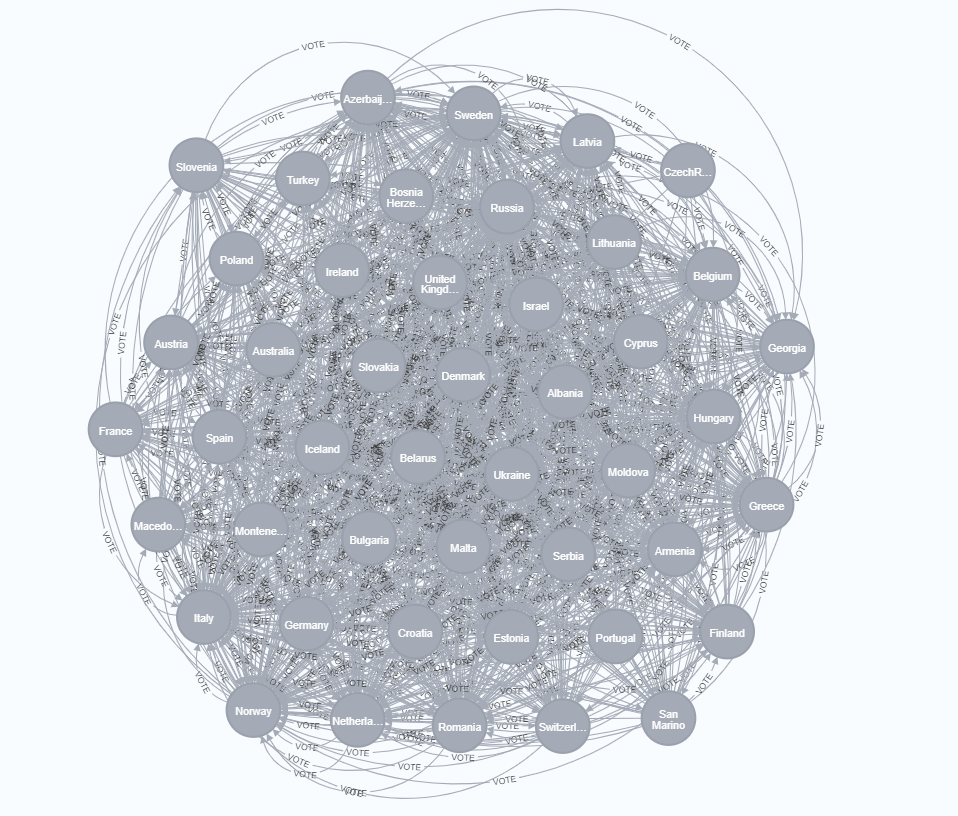

## Exploring the Data <a name="exploring"></a>

#### Which country received the highest sum of scores over these years

In [10]:
query_string = '''
MATCH (from:Country)-[v]->(to:Country)
RETURN to.name, sum(v.score) as totalScore
ORDER BY totalScore DESC LIMIT 10
'''
conn.query(query_string, db='coradb')

[<Record to.name='Sweden' totalScore=1008>,
 <Record to.name='Russia' totalScore=827>,
 <Record to.name='Italy' totalScore=555>,
 <Record to.name='Azerbaijan' totalScore=466>,
 <Record to.name='Ukraine' totalScore=392>,
 <Record to.name='Norway' totalScore=382>,
 <Record to.name='Denmark' totalScore=371>,
 <Record to.name='Netherlands' totalScore=342>,
 <Record to.name='Belgium' totalScore=288>,
 <Record to.name='Austria' totalScore=278>]

####  Adding up all votes from all year from country a to country b

In [11]:
query_string = '''
MATCH (from:Country)-[v]->(to:Country)
WITH from, to, sum(v.score) as totalvotes
MERGE (from)-[r:VOTES_ALL {total:totalvotes}]->(to)
RETURN from.name, to.name,totalvotes
ORDER BY totalvotes DESC LIMIT 10
'''
conn.query(query_string, db='coradb')

[<Record from.name='Moldova' to.name='Romania' totalvotes=46>,
 <Record from.name='Denmark' to.name='Sweden' totalvotes=44>,
 <Record from.name='Belarus' to.name='Russia' totalvotes=44>,
 <Record from.name='Norway' to.name='Sweden' totalvotes=44>,
 <Record from.name='Malta' to.name='Italy' totalvotes=42>,
 <Record from.name='Albania' to.name='Italy' totalvotes=41>,
 <Record from.name='Georgia' to.name='Azerbaijan' totalvotes=39>,
 <Record from.name='Finland' to.name='Sweden' totalvotes=38>,
 <Record from.name='Latvia' to.name='Sweden' totalvotes=36>,
 <Record from.name='Slovenia' to.name='Sweden' totalvotes=36>]

#### Which country received 12 points from other countries most often

In [12]:
query_string = '''
MATCH (from:Country)-[v:VOTE{score:12}]->(to:Country)
RETURN to.name, count(v.score) as MaxPoints
ORDER BY MaxPoints DESC LIMIT 10
'''
conn.query(query_string, db='coradb')

[<Record to.name='Sweden' MaxPoints=34>,
 <Record to.name='Azerbaijan' MaxPoints=16>,
 <Record to.name='Italy' MaxPoints=13>,
 <Record to.name='Austria' MaxPoints=12>,
 <Record to.name='Russia' MaxPoints=10>,
 <Record to.name='Netherlands' MaxPoints=9>,
 <Record to.name='Denmark' MaxPoints=8>,
 <Record to.name='Albania' MaxPoints=5>,
 <Record to.name='Ukraine' MaxPoints=5>,
 <Record to.name='Serbia' MaxPoints=5>]

#### Which country received 1 point from other countries most often. Sweden seems to be the most popular country.

In [13]:
query_string = '''
MATCH (from:Country)-[v:VOTE {score:1}]->(to:Country)
RETURN to.name, count(v.score) as MinPoints
ORDER BY MinPoints DESC LIMIT 10
'''
conn.query(query_string, db='coradb')

[<Record to.name='Greece' MinPoints=9>,
 <Record to.name='Ukraine' MinPoints=8>,
 <Record to.name='Spain' MinPoints=8>,
 <Record to.name='Hungary' MinPoints=8>,
 <Record to.name='Romania' MinPoints=8>,
 <Record to.name='United Kingdom' MinPoints=7>,
 <Record to.name='Italy' MinPoints=7>,
 <Record to.name='Denmark' MinPoints=7>,
 <Record to.name='Lithuania' MinPoints=6>,
 <Record to.name='Norway' MinPoints=5>]

####  Looking at the influence of neighbors on the votes
- Inspiration and Data from https://memgraph.com/blog/analyzing-the-eurovision-song-contest-with-graphs


In [14]:
query_string = '''
LOAD CSV WITH HEADERS FROM "https://raw.githubusercontent.com/jackmheller/modernDataAnalytics/main/Data/GEODATASOURCE-COUNTRY-BORDERS.csv" AS row  

  

MATCH (FromCountry:Country {name: row.country_name})  

  

MATCH (ToCountry:Country {name: row.country_border_name})  

  

CREATE (FromCountry)-[B:BORDER]->(ToCountry); 

 
'''
conn.query(query_string, db='coradb')

[]

#### How many neighbors do the countries have? We expect more bias in neighboring countries

In [15]:
query_string = '''
MATCH (c1:Country)-[r:BORDER]-(c2:Country)
WITH DISTINCT c2.name AS Neighbor, c1.name as Country
RETURN Country, COUNT(Neighbor) AS Number_of_neighbors
ORDER BY Number_of_neighbors DESC LIMIT 10;
'''
conn.query(query_string, db='coradb')

[<Record Country='Russia' Number_of_neighbors=10>,
 <Record Country='Hungary' Number_of_neighbors=7>,
 <Record Country='Germany' Number_of_neighbors=7>,
 <Record Country='Serbia' Number_of_neighbors=6>,
 <Record Country='Poland' Number_of_neighbors=6>,
 <Record Country='Ukraine' Number_of_neighbors=6>,
 <Record Country='Austria' Number_of_neighbors=6>,
 <Record Country='Italy' Number_of_neighbors=5>,
 <Record Country='Belarus' Number_of_neighbors=5>,
 <Record Country='Turkey' Number_of_neighbors=5>]

Looking at the ESC 2012, where the top 3 were Sweden, Russia and Serbia
- How much of the votes are coming from direct neighbors of a country?

In [16]:
query_string = '''

MATCH (c1:Country)-[b:BORDER ]-(c2:Country {name: 'Sweden'}),
      (c1:Country)-[v:VOTE {year: 2012}]->(c2:Country)
WITH sum(v.score) AS border_vote, c2.name AS name
MATCH (:Country)-[v:VOTE {year: 2012} ]->(c:Country {name: 'Sweden'})
RETURN v.year, c.name AS Country, sum(v.score) AS Points, sum(v.score)-border_vote AS Points_without_neighbours;
'''
conn.query(query_string, db='coradb')


[<Record v.year=2012 Country='Sweden' Points=372 Points_without_neighbours=324>]

In [17]:
query_string = '''

MATCH (c1:Country)-[b:BORDER ]-(c2:Country {name: 'Serbia'}),
      (c1:Country)-[v:VOTE {year: 2012}]->(c2:Country)
WITH sum(v.score) AS border_vote, c2.name AS name
MATCH (:Country)-[v:VOTE {year: 2012} ]->(c:Country {name: 'Serbia'})
RETURN v.year, c.name AS Country, sum(v.score) AS Points, sum(v.score)-border_vote AS Points_without_neighbours;
'''
conn.query(query_string, db='coradb')

[<Record v.year=2012 Country='Serbia' Points=214 Points_without_neighbours=122>]

In [18]:
query_string = '''

MATCH (c1:Country)-[b:BORDER ]-(c2:Country {name: 'Russia'}),
      (c1:Country)-[v:VOTE {year: 2012}]->(c2:Country)
WITH sum(v.score) AS border_vote, c2.name AS name
MATCH (:Country)-[v:VOTE {year: 2012} ]->(c:Country {name: 'Russia'})
RETURN v.year, c.name AS Country, sum(v.score) AS Points, sum(v.score)-border_vote AS Points_without_neighbours;
'''
conn.query(query_string, db='coradb')


[<Record v.year=2012 Country='Russia' Points=259 Points_without_neighbours=105>]

While Russia and Serbia clearly have more neighbors than Sweden, at first glance it still seems like eastern european countries show more dependence on votes from neighbors 

## Centrality Measures <a name="centrality"></a>

- Degree Centrality 
- Betweenness Centrality 


Methods are based on Neo4j documentation from

https://neo4j-website.s3.eu-central-1.amazonaws.com/build/html/Algorithms/centrality/centrality.html and 

https://neo4j.com/docs/graph-data-science/current/algorithms/centrality/ 

Storing the Graph before using it, the orientation is set to "REVERSE" since the graph is directed and we are interested in the countries with the most incoming votes

In [19]:
query_string = '''
CALL gds.graph.project( 

  'myGraph', 

  'Country', 

  { 

    VOTE: { 

      orientation: 'REVERSE', 

      properties: ['score'] 

    } 

  } 

) 
'''
conn.query(query_string, db='coradb')

[<Record nodeProjection={'Country': {'label': 'Country', 'properties': {}}} relationshipProjection={'VOTE': {'orientation': 'REVERSE', 'aggregation': 'DEFAULT', 'type': 'VOTE', 'properties': {'score': {'defaultValue': None, 'property': 'score', 'aggregation': 'DEFAULT'}}}} graphName='myGraph' nodeCount=46 relationshipCount=1570 projectMillis=204>]

### Degree Centrality
Goal: find out about the popularity of the countries 

#### First without using the scores countries gave one-another as weight

In [20]:
query_string = '''
CALL gds.degree.stream('myGraph') 

YIELD nodeId, score 

RETURN gds.util.asNode(nodeId).name AS name, score AS Voters 

ORDER BY Voters DESC, name DESC LIMIT 10
'''
conn.query(query_string, db='coradb')

[<Record name='Sweden' Voters=122.0>,
 <Record name='Russia' Voters=117.0>,
 <Record name='Italy' Voters=89.0>,
 <Record name='Norway' Voters=77.0>,
 <Record name='Ukraine' Voters=63.0>,
 <Record name='Azerbaijan' Voters=63.0>,
 <Record name='Denmark' Voters=60.0>,
 <Record name='Greece' Voters=54.0>,
 <Record name='Belgium' Voters=52.0>,
 <Record name='Hungary' Voters=51.0>]

#### Now using the scores as weights 

In [21]:

query_string = '''
CALL gds.degree.stream( 

   'myGraph', 

   { relationshipWeightProperty: 'score' } 

) 

YIELD nodeId, score 

RETURN gds.util.asNode(nodeId).name AS name, score AS weightedVoters 

ORDER BY weightedVoters DESC, name DESC LIMIT 10
'''
conn.query(query_string, db='coradb')


[<Record name='Sweden' weightedVoters=1008.0>,
 <Record name='Russia' weightedVoters=827.0>,
 <Record name='Italy' weightedVoters=555.0>,
 <Record name='Azerbaijan' weightedVoters=466.0>,
 <Record name='Ukraine' weightedVoters=392.0>,
 <Record name='Norway' weightedVoters=382.0>,
 <Record name='Denmark' weightedVoters=371.0>,
 <Record name='Netherlands' weightedVoters=342.0>,
 <Record name='Belgium' weightedVoters=288.0>,
 <Record name='Austria' weightedVoters=278.0>]

- The top 3 popular countries: Sweden, Russia and Italy stay the same, regardless of whether weights are used, the following countries change slightly
- We expect the results to be more representative when incorperating scores as weights, since giving a country 1 point is not the same as giving a country 12 points


### Betweenness Centrality
Goal: find out which countries acts as a "middleman"

In [22]:

query_string = '''
CALL gds.betweenness.stream('myGraph') 

YIELD nodeId, score 

RETURN gds.util.asNode(nodeId).name AS name, score 

ORDER BY score DESC, name DESC LIMIT 10
'''
conn.query(query_string, db='coradb')

[<Record name='Sweden' score=102.6917131060264>,
 <Record name='Azerbaijan' score=60.63698678183106>,
 <Record name='Italy' score=56.7048243511971>,
 <Record name='Russia' score=55.50870029745551>,
 <Record name='Hungary' score=41.14137523583487>,
 <Record name='Serbia' score=33.753451310091585>,
 <Record name='Armenia' score=31.182400878168046>,
 <Record name='Norway' score=29.269547118767406>,
 <Record name='Greece' score=28.141615339016585>,
 <Record name='Belgium' score=24.709277170967272>]

Again, the top 3 countries do not change. Hungary seems to be a country which is more of a "middleman" than a very popular country in eurovision

- We are not using closeness centrality since for us it is less important to see which countries spread information through the ESC
- We are not using PageRank since our graph is not directed

#### Page Rank

This measures importance of each node within the graph, based on the number incoming votes and the importance of the corresponding source countries

Formula: $PR(A)=(1-d)+d*(\frac{PR(T_1)}{C(T_1)} +...+ \frac{PR(T_n)}{C(T_n)}) $

Source: https://neo4j.com/docs/graph-data-science/current/algorithms/page-rank/

In [23]:

query_string = '''
CALL gds.graph.project(
  'myGraph1',
  'Country',
  'VOTE',
  {
    relationshipProperties: 'score'
  }
)
'''
conn.query(query_string, db='coradb')

[<Record nodeProjection={'Country': {'label': 'Country', 'properties': {}}} relationshipProjection={'VOTE': {'orientation': 'NATURAL', 'aggregation': 'DEFAULT', 'type': 'VOTE', 'properties': {'score': {'defaultValue': None, 'property': 'score', 'aggregation': 'DEFAULT'}}}} graphName='myGraph1' nodeCount=46 relationshipCount=1570 projectMillis=62>]

In [24]:

query_string = '''
CALL gds.pageRank.stream('myGraph1')
YIELD nodeId, score
RETURN gds.util.asNode(nodeId).name AS name, score
ORDER BY score DESC, name ASC LIMIT 10
'''
conn.query(query_string, db='coradb')

[<Record name='Sweden' score=2.8913645666716037>,
 <Record name='Russia' score=2.82501470261818>,
 <Record name='Norway' score=2.028083941348823>,
 <Record name='Italy' score=1.9929110662276848>,
 <Record name='Ukraine' score=1.7294604621476786>,
 <Record name='Denmark' score=1.5833913199418286>,
 <Record name='Azerbaijan' score=1.5288956577712058>,
 <Record name='Greece' score=1.476216893333041>,
 <Record name='Belgium' score=1.4504669821085256>,
 <Record name='Estonia' score=1.4043905152031455>]

The maximal number of iterations and the damping factor are the ones suggested by Neo4j and in the Lectures 

In [25]:

query_string = '''
CALL gds.pageRank.stream('myGraph1', {
  maxIterations: 20,
  dampingFactor: 0.85,
  relationshipWeightProperty: 'score'
})
YIELD nodeId, score
RETURN gds.util.asNode(nodeId).name AS name, score
ORDER BY score DESC, name ASC LIMIT 10
'''
conn.query(query_string, db='coradb')

[<Record name='Sweden' score=4.024767676951307>,
 <Record name='Russia' score=3.456494826521819>,
 <Record name='Italy' score=2.1398172925124848>,
 <Record name='Azerbaijan' score=1.9954280104703606>,
 <Record name='Norway' score=1.8194050811138025>,
 <Record name='Ukraine' score=1.7613574802006826>,
 <Record name='Denmark' score=1.638094061952113>,
 <Record name='Belgium' score=1.5964787797589897>,
 <Record name='Netherlands' score=1.5917238558954563>,
 <Record name='Greece' score=1.3184516179884798>]

## Community Detection using Louvain <a name="community"></a>

First we are storing the graph

As reported by Neo4j documentation, the orientation set to UNDIRECTED as this works best with the Louvain algorithm.

In [26]:

query_string = '''
CALL gds.graph.project( 

    'myGraph2', 

    'Country', 

    { 

        VOTE: { 

            orientation: 'UNDIRECTED' 

        } 

    }, 

    { 

        relationshipProperties: 'score' 

    } 

) 

'''
conn.query(query_string, db='coradb')

[<Record nodeProjection={'Country': {'label': 'Country', 'properties': {}}} relationshipProjection={'VOTE': {'orientation': 'UNDIRECTED', 'aggregation': 'DEFAULT', 'type': 'VOTE', 'properties': {'score': {'defaultValue': None, 'property': 'score', 'aggregation': 'DEFAULT'}}}} graphName='myGraph2' nodeCount=46 relationshipCount=3140 projectMillis=37>]

#### Creating communities based on voting patterns, not incoperating scores as weights. Saving the output as a dataframe

In [29]:

query_string = '''
CALL gds.louvain.stream('myGraph2') 

YIELD nodeId, communityId, intermediateCommunityIds 

RETURN gds.util.asNode(nodeId).name AS name, communityId, intermediateCommunityIds 

ORDER BY communityId, name  ASC 

'''
conn.query(query_string, db='coradb')


group_unweighted_votes = pd.DataFrame([dict(_) for _ in conn.query(query_string, db='coradb')])
group_unweighted_votes.head(10)

name  communityId intermediateCommunityIds
0         Cyprus           10                     None
1         Israel           10                     None
2       Portugal           10                     None
3        Romania           10                     None
4          Spain           10                     None
5        Armenia           11                     None
6     Azerbaijan           11                     None
7        Belarus           11                     None
8       Bulgaria           11                     None
9  CzechRepublic           11                     None

#### Creating communities based on voting patterns, incoperating scores as weights

In [31]:

query_string = '''
CALL gds.louvain.stream('myGraph2', { relationshipWeightProperty: 'score' }) 

YIELD nodeId, communityId, intermediateCommunityIds 

RETURN gds.util.asNode(nodeId).name AS name, communityId, intermediateCommunityIds 

ORDER BY communityId, name ASC 

 
'''
conn.query(query_string, db='coradb')


group_weighted_votes = pd.DataFrame([dict(_) for _ in conn.query(query_string, db='coradb')])
group_weighted_votes.head(10)

name  communityId intermediateCommunityIds
0  Australia            8                     None
1    Austria            8                     None
2    Belgium            8                     None
3    Denmark            8                     None
4    Estonia            8                     None
5    Finland            8                     None
6     France            8                     None
7    Germany            8                     None
8    Hungary            8                     None
9    Iceland            8                     None

## Using mean votes
- When looking at all of the votes, almost every country has a connection with another country at some point
- We are therefore constructing a mean-score of what country A gives to country B, averaged over the years
- We believe that this way we can detect communities in a more consistent way


Deleting the previous relationships, since we are now interested in the mean of the votes

In [32]:

query_string = '''
match (:Country)-[r:VOTE]->(:Country) 
match (:Country)-[b:BORDER]->(:Country) 


DELETE r, b ; 
'''
conn.query(query_string, db='coradb')

[]

Before continuing our network analysis we will first prepare the data 


In [33]:
url='https://raw.githubusercontent.com/jackmheller/modernDataAnalytics/main/Data/eurovision_song_contest_1975_2022.csv'
df = pd.read_csv(url)
relevantYears = [*range(2008,2023,1)]
df = df[df["Year"].isin(relevantYears)]
df = df[df["(semi-) final"] == 'f']
df = df[['From country', 'To country', 'Points']]
df

From country            To country  Points
21264         Albania               Albania       0
21265         Albania               Armenia       2
21266         Albania            Azerbaijan       0
21267         Albania  Bosnia & Herzegovina       0
21268         Albania               Croatia       0
...               ...                   ...     ...
56307  United Kingdom                Serbia       1
56308  United Kingdom                 Spain       5
56309  United Kingdom                Sweden       4
56310  United Kingdom           Switzerland       0
56311  United Kingdom               Ukraine      12

[20858 rows x 3 columns]

Since every country has a mean vote for another country, we want to make the connections more meaninful by deleting all connections with a mean vote smaller than 6. We believe that a mean vote under this value is not an indicator for a consistent connection between the countries. 

In [34]:
df['Points'] = df['Points'].astype(int)

df
df1 = df.groupby(['From country', 'To country'])['Points'].count().reset_index().sort_values(by='Points', axis = 0, ascending=False)
df2 = df.groupby(['From country', 'To country'])['Points'].mean().reset_index().sort_values(by='Points', axis = 0, ascending=False)
df2.columns=['FromCountry', 'ToCountry', 'MeanPoints']
df1.columns=['FromCountry', 'ToCountry', 'NumVotes']
df3 = df1.merge(df2, on = ['FromCountry', 'ToCountry'], how = 'outer')
df3 = df3[df3['MeanPoints'] >= 6]
df3 = df3[df3['NumVotes'] >= 3]
del df3['NumVotes']
# Fix country name problems
df3.replace(['F.Y.R. Macedonia', 'North Macedonia'], 'Macedonia', inplace = True)
df3.replace(['The Netherands', 'The Netherlands'], 'Netherlands', inplace = True)
df3

FromCountry             ToCountry  MeanPoints
85       Iceland                Sweden    7.315789
99       Finland                Sweden    7.947368
101      Estonia                Sweden    6.526316
108      Denmark                Sweden    8.842105
114       Norway                Sweden    7.894737
...          ...                   ...         ...
1905     Georgia                Turkey    6.000000
1918      Turkey               Armenia    7.333333
1933    Slovakia                Sweden    7.333333
1937    Slovakia               Estonia    7.333333
1938  Montenegro  Bosnia & Herzegovina    9.333333

[108 rows x 3 columns]

## Loading the new Relationships into neo4j

In [35]:
query_string = '''
LOAD CSV WITH HEADERS FROM "https://raw.githubusercontent.com/jackmheller/modernDataAnalytics/main/Data/VoteMean6.csv" AS row  

  

MATCH (FromCountry:Country {name: row.FromCountry})  

  

MATCH (ToCountry:Country {name: row.ToCountry})  

  

CREATE (FromCountry)-[:MeanPoints {Connection:row.MeanPoints}]->(ToCountry); 

 
'''
conn.query(query_string, db='coradb')

[]

As can be seen in the picture, using mean-votes makes the connections a lot more clear 

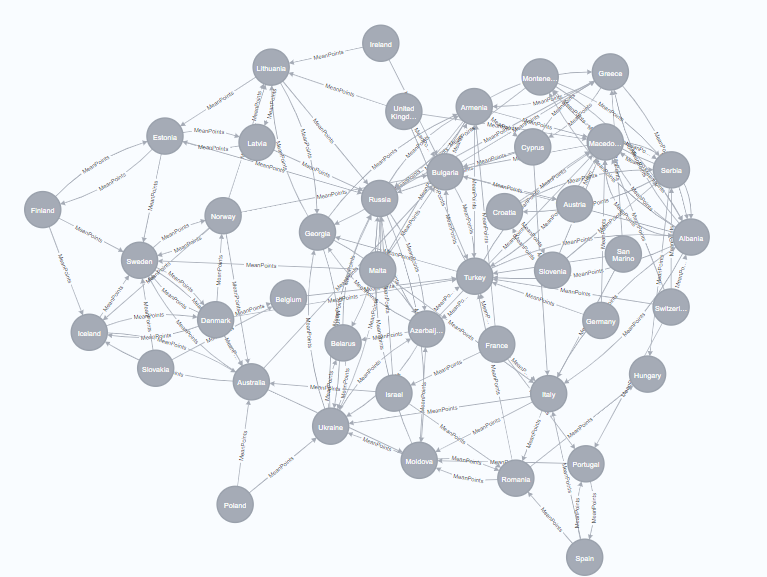

### Community Detection using Louvain (now using Mean Votes)

First, we are storing the graph

In [36]:
query_string = '''
CALL gds.graph.project(  

'myGraph3',  

'Country',  

{  

MeanPoints: {  

orientation: 'UNDIRECTED'  

}  

}, 
 

{  

relationshipProperties: toFloat('Connection')  

}  

) 

 
'''
conn.query(query_string, db='coradb')


[<Record nodeProjection={'Country': {'label': 'Country', 'properties': {}}} relationshipProjection={'MeanPoints': {'orientation': 'UNDIRECTED', 'aggregation': 'DEFAULT', 'type': 'MeanPoints', 'properties': {}}} graphName='myGraph3' nodeCount=46 relationshipCount=318 projectMillis=28>]

Storing the new communities in a dataframe

In [37]:
query_string = '''
CALL gds.louvain.stream('myGraph3')  

 
 

YIELD nodeId, communityId, intermediateCommunityIds  

 
 

RETURN gds.util.asNode(nodeId).name AS name, communityId, intermediateCommunityIds  

 
 

ORDER BY communityId ASC 
 
'''
conn.query(query_string, db='coradb')

group_unweighted_Mean = pd.DataFrame([dict(_) for _ in conn.query(query_string, db='coradb')])
group_unweighted_Mean.head()

name  communityId intermediateCommunityIds
0    Malta            8                     None
1  Estonia            8                     None
2  Finland            8                     None
3  Belgium            8                     None
4  Denmark            8                     None

### Next we compute year by year biases

These are calculated by taking the mean vote for a country by year and then calculating the mean difference between this value and country's vote over multiple years

In [38]:
url='https://raw.githubusercontent.com/jackmheller/modernDataAnalytics/main/Data/eurovision_song_contest_1975_2022.csv'
df = pd.read_csv(url)
relevantYears = [*range(2008,2023,1)]
df = df[df["Year"].isin(relevantYears)]
df = df[df["(semi-) final"] == 'f']
df = df[df['From country'] != df['To country']]
df2 = df.groupby(['To country', "Year"])['Points'].agg('mean').rename('MeanPoints').reset_index()
df = df.merge(df2, on = ['To country','Year'])
df['Diff'] = df['Points'] - df['MeanPoints']
df = df.groupby(['From country', 'To country'])['Diff'].agg('mean').rename('True_Bias').reset_index().sort_values('True_Bias')
df


From country        To country  True_Bias
1413           Netherlands            Sweden  -4.038462
1541                Poland            Turkey  -4.025491
1807              Slovakia            Turkey  -3.840822
507                 Cyprus   North Macedonia  -3.812500
1887                 Spain   North Macedonia  -3.812500
...                    ...               ...        ...
898                 Greece            Cyprus   9.834032
1741                Serbia  F.Y.R. Macedonia  10.268293
359   Bosnia & Herzegovina  F.Y.R. Macedonia  10.268293
1756                Serbia        Montenegro  10.871795
70                 Andorra             Spain  11.064750

[2168 rows x 3 columns]

Above we can see that there is a strong bias for Andorra to vote for Spain as well as Serbia to vote for Montenegro.  While there is also a negative bias for Netherlands voting for Sweden and Poland for Turkey.

In [40]:
#df.to_csv('yearBias.csv')

In [41]:
url='https://raw.githubusercontent.com/jackmheller/modernDataAnalytics/main/Data/eurovision_song_contest_1975_2022.csv'
df = pd.read_csv(url)
relevantYears = [*range(2008,2023,1)]
df = df[df["Year"].isin(relevantYears)]
df = df[df["(semi-) final"] == 'f']
df = df[df['From country'] != df['To country']]
df2 = df.groupby(['To country', "Year"])['Points'].agg('mean').rename('MeanPoints').reset_index()
df = df.merge(df2, on = ['To country', 'Year'])
df['Diff'] = df['Points'] - df['MeanPoints']

df.loc[df['Diff'] < 0, 'Diff'] = -1
df.loc[df['Diff'] > 0, 'Diff'] = 1

df = df.groupby(['From country', 'To country'])['Diff'].agg('sum').rename('Bias').reset_index().sort_values('Bias')
df

From country To country  Bias
1018      Iceland      Spain -20.0
226    Azerbaijan    Germany -19.0
1319      Moldova    Germany -19.0
1273        Malta    Germany -19.0
494        Cyprus    Germany -18.0
...           ...        ...   ...
495        Cyprus     Greece  15.0
1279        Malta      Italy  15.0
1019      Iceland     Sweden  15.0
744       Finland     Sweden  17.0
608       Denmark     Sweden  19.0

[2168 rows x 3 columns]

In [42]:
#df.to_csv('countBias.csv')

# Song Sentiment Analysis <a name="sentiment"></a>


A sentiment analysis was conducted on the winning songs of the years 2010-2022. 
Polarity scores for each year were calculated and then plotted. 
Values equal to 0 are considered as neutral sentiments while values above and below 0 are considered as positive and negative sentiments respectively. 

In [4]:
#Creating the function to calculate polarity 
def blob_sentiment(txt):
    sent = TextBlob(txt).sentiment.polarity
    return sent

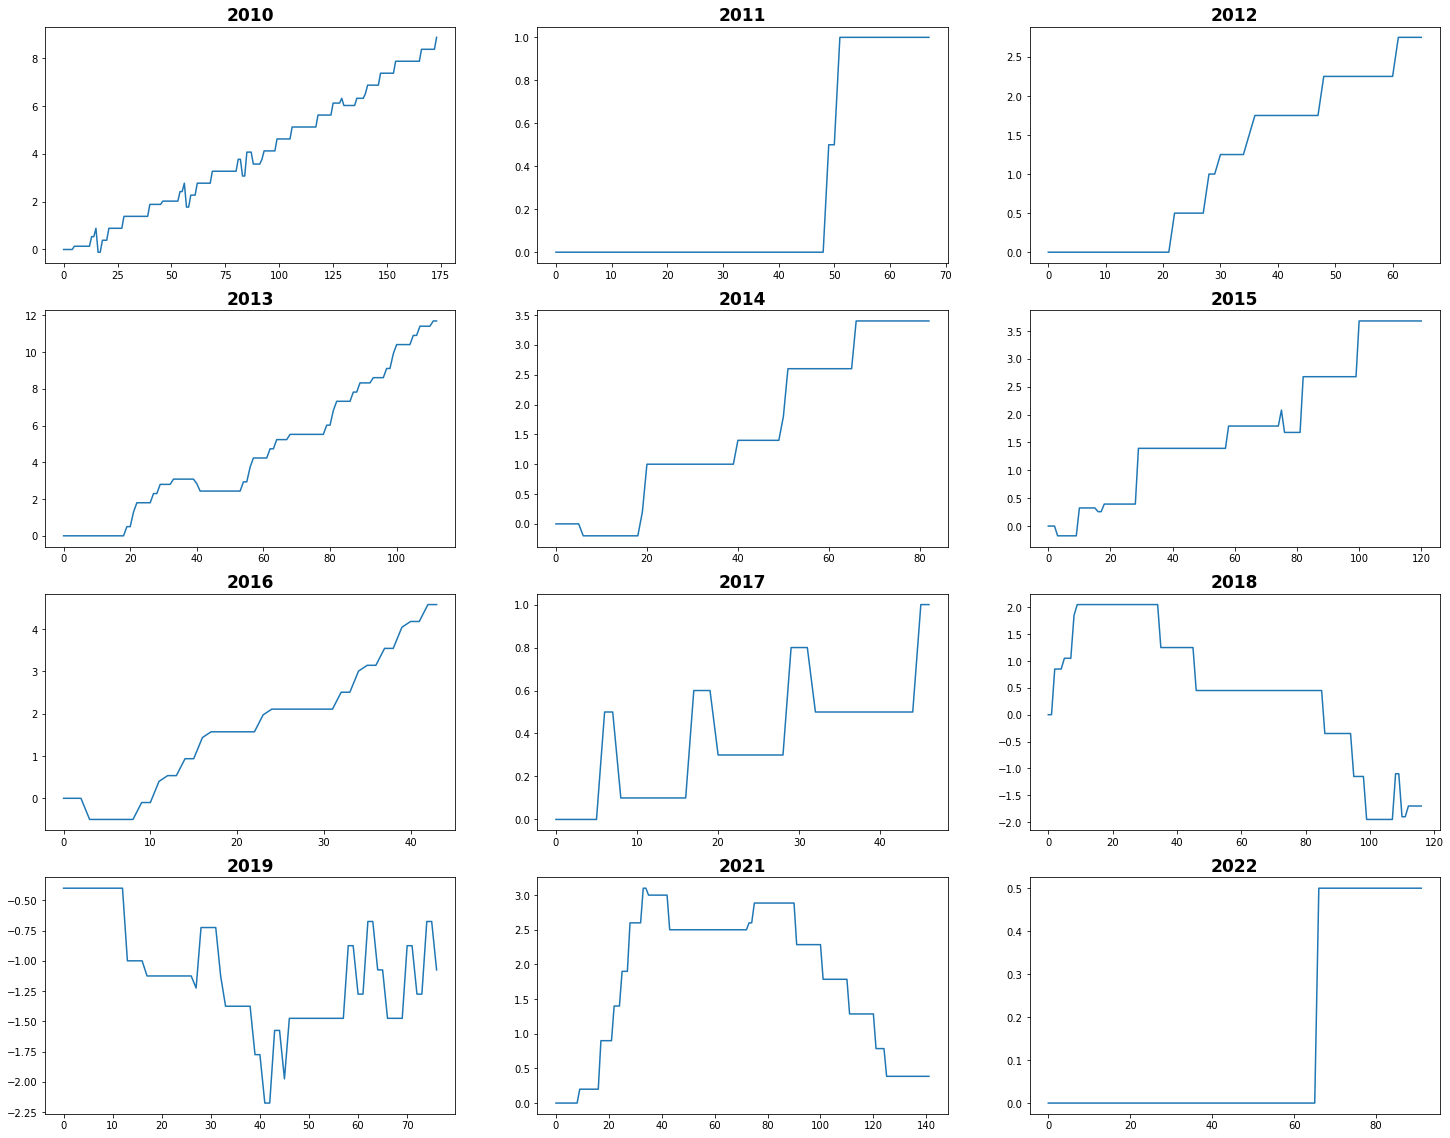

In [5]:
fig , ax = plt.subplots(4,3,figsize=(25,20))
grid_list = []

for row in range(0,4):
    for col in range(0,3):
        grid_list.append((row,col))
        
for y_id,year in enumerate(range(2010,2023)):
    if year==2020:
        continue
    else:
#         print(year)
        url="https://raw.githubusercontent.com/jackmheller/modernDataAnalytics/main/Data/Lyrics%202/{}.txt".format(year)
        # read text file into pandas DataFrame
        df = requests.get(url)

        # display DataFrame
        text = df.text

        words = text.split()  
        alphabetic_only = [word for word in words if word.isalpha()]
        lower_case = [word.lower() for word in alphabetic_only]

        sw = stopwords.words('english')
        sw.append('oh') #adding the word 'oh' to the list of stopwords
        cleaned_words = [word for word in lower_case if word not in sw]

        df = pd.DataFrame(cleaned_words)
        df.columns = ['text']
        df['sentiment_blob'] = ''


        df['sentiment_blob'] = df['text'].apply(lambda x : blob_sentiment(x))

        if year in [2021,2022]:
            y_id-=1
        ax[grid_list[y_id]].plot(np.arange(0,len(df)),df['sentiment_blob'].cumsum(),label='Text Blob')
        ax[grid_list[y_id]].set_title(year,fontsize=17,fontweight='bold')


### Wordcloud Generation

A wordcloud was generated using the WordCloud function for the same set of winning songs through the years 2010-2022.
Since the analysis was done on song lyrics, the most frequently used words are usually the words found in either the title of the song or the chorus of the song. 


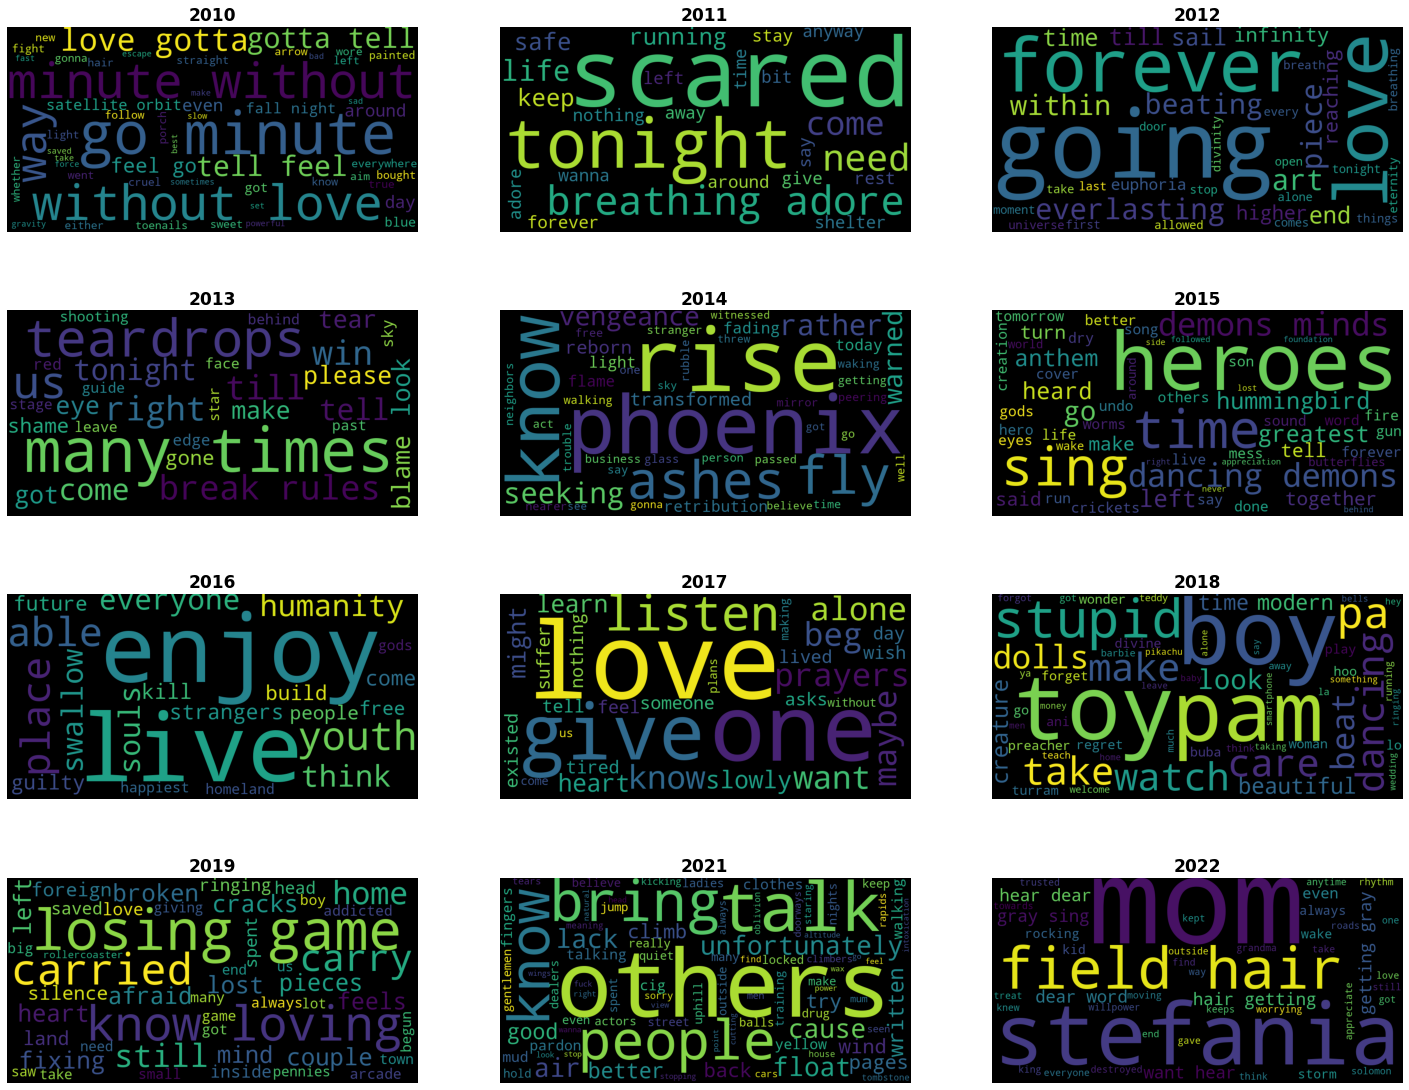

In [6]:
fig , ax = plt.subplots(4,3,figsize=(25,20))

grid_list = []

for row in range(0,4):
    for col in range(0,3):
        grid_list.append((row,col))
        
for y_id,year in enumerate(range(2010,2023)):
    if year==2020:
        continue
    else:
#         print(year)
        url="https://raw.githubusercontent.com/jackmheller/modernDataAnalytics/main/Data/Lyrics%202/{}.txt".format(year)
        # read text file into pandas DataFrame
        df = requests.get(url)

        text = df.text

        words = text.split()
        alphabetic_only = [word for word in words if word.isalpha()]
        lower_case = [word.lower() for word in alphabetic_only]

        sw = stopwords.words('english')
        sw.append('oh') #adding the word 'oh' to the list of stopwords
        cleaned_words = [word for word in lower_case if word not in sw]

        if year in [2021,2022]:
            y_id-=1
        unique_string=(" ").join(cleaned_words)
        wordcloud = WordCloud(width = 1000, height = 500).generate(unique_string)
        ax[grid_list[y_id]].imshow(wordcloud)
        ax[grid_list[y_id]].axis("off")
        ax[grid_list[y_id]].set_title(year,fontsize=17,fontweight='bold')


The word 'love' is observed more frequently in the earlier years compared to recent years. 

# Multiple Regression Quadratic Assignment Procedure (MRQAP)   <a name="mqrap"></a>

This section is looking at community detection using networkx and also using a quadratic assignment procedure to perform what is essentially a network regression to see if there is any relation between distance, bilateral trade value, and points awarded

In [ ]:
# for finding data in the "data" folder
_DATA_DIRECTORY = 'https://raw.githubusercontent.com/jackmheller/modernDataAnalytics/main/Data/'

def full_path(path):
    return os.path.join(_DATA_DIRECTORY, path)

# importing data from github
main_datafile = 'https://raw.githubusercontent.com/jackmheller/modernDataAnalytics/main/Data/eurovision_song_contest_1975_2019.csv'
longform_data = pd.read_csv(main_datafile)



In [20]:
# this is a function that allows you to get data from any year or voting type or round type 
def Eurovision_Decade_DataFrame(longform_data, vote_type = "Both", round_type = "all", y1="NA", y2="NA"):
    # probably enforce types or something here    
    longform_data = longform_data[longform_data["From country"] != longform_data["To country"]]
    longform_data = longform_data.replace('F.Y.R. Macedonia','Macedonia')
    contest_round = list(longform_data['(semi-) final'].unique())
    for version in contest_round:
        locals()["census_"+str(version)] = longform_data[longform_data['(semi-) final']==version].groupby('Year').nunique()[['From country','To country']]
        locals()["census_"+str(version)]['(semi-) final'] = str(version)
        locals()["census_"+str(version)].reset_index()
        locals()["census_"+str(version)].rename(columns = {'From country':'sum_senders_'+str(version), 'To country':'sum_receivers_'+str(version)}, inplace = True)
        if contest_round.index(version) == 0: 
            merged_rounds = pd.merge(longform_data, locals()["census_"+str(version)], how='left', on=['Year', '(semi-) final'])
        else:
            merged_rounds = pd.merge(merged_rounds, locals()["census_"+str(version)], how='left', on=['Year', '(semi-) final'])
    merged_rounds = merged_rounds.fillna(0)

    merged_rounds["sum_senders"] = merged_rounds["sum_senders_sf"] + merged_rounds["sum_senders_sf1"] + merged_rounds["sum_senders_f"] + merged_rounds["sum_senders_sf2"] 
    merged_rounds["sum_receivers"] = merged_rounds["sum_receivers_sf"] + merged_rounds["sum_receivers_sf2"] + merged_rounds["sum_receivers_f"]  + merged_rounds["sum_receivers_sf1"] 
    merged_rounds = merged_rounds.drop(['sum_senders_sf', 'sum_senders_sf1', "sum_senders_f", 'sum_senders_sf2', 'sum_receivers_sf', "sum_receivers_sf2", "sum_receivers_f", "sum_receivers_sf1"], axis=1)
    merged_rounds['Decade'] = (10 * (merged_rounds['Year'] // 10)).astype(str) + 's'
    merged_rounds["average_points"] = merged_rounds["Points"]/merged_rounds["sum_senders"]
    
    if round_type != "all" and round_type == "finals":
        merged_rounds = merged_rounds[merged_rounds['(semi-) final'] == "f"]
    elif round_type != "all" and round_type == "semis":
        merged_rounds = merged_rounds[(merged_rounds['(semi-) final'] == "sf") | (merged_rounds['(semi-) final'] == "sf1") | (merged_rounds['(semi-) final'] == "sf2")]
    else:
        pass
    merged_rounds["contests_incl"] = str(round_type)
    
    if y1 != "NA" and y2 != "NA":
        merged_rounds = merged_rounds[(merged_rounds['Year'] >= y1) & (merged_rounds['Year'] <= y2)]
    else:
        pass
    
    if vote_type == "J" or vote_type == "T":
        merged_rounds = merged_rounds[merged_rounds["Jury or Televoting"] == vote_type]
        decade_grouping = merged_rounds.groupby(["Decade","From country", "To country"]).sum()
        decade_grouping = decade_grouping.reset_index()
    else:
        decade_grouping = merged_rounds.groupby(["Decade","From country", "To country"]).sum()
        decade_grouping = decade_grouping.reset_index()
    decade_grouping["Contests_Shared"] = (decade_grouping["Year"]/2000).round(0).astype(int)
    return decade_grouping

# helper function to subset the data by decade (not really super needed)
def Decade_subset(df_decades, decade="all"):
    if decade == "all":
        return df_decades     
    else:
        locals()["eurovision_"+str(decade)] = df_decades[df_decades["Decade"] == str(decade)+"s"].sort_values(by=['average_points'],  ascending=False)
        return locals()["eurovision_"+str(decade)]

## Fuzzy Matching helper functions
Useful because our Eurovision data and the data that we find online for trade and distance use different spellings for different countries. We wanted to be sure that we were capturing the most data we could while still retaining its usefulness.  

In [22]:
# this is a function to find similar countries for fuzzy matching
def similar(landstring, country):
    similar = process.extractOne(landstring, country, score_cutoff=90)
    if similar == None:
        return "NA"
    else:
        return similar[0]
    

# fn for merging on keys that match at the 90% threshold
def fuzzy_merge(df_1, df_2, key1, key2, threshold=90, limit=1):
    s = df_2[key2].tolist()
    m = df_1[key1].apply(lambda x: process.extract(x, s, limit=limit))    
    df_1['matches'] = m
    m2 = df_1['matches'].apply(lambda x: ', '.join([i[0] for i in x if i[1] >= threshold]))
    df_1['matches'] = m2
    
    return df_1

## In the following cell I use geopy to get distances between two countries in kilometers
The country location is set by the geographic center of the country, so for some weirdly shaped countries (Croatia) this may lead to some strangeness in how distance is considered, but it should measure what we want..

In [28]:

# this function grabs the data for distance and cleans it and finds the distance in kilometers
def proc_distance(dataframe):
    country = pd.read_csv(full_path(dataframe), delimiter=";", names=["Country", "Lat", "Lon"])
    pos = dict((land, similar(land.upper(), country["Country"])) for land in Country_data["From country"].unique())
    take_2_2 = pd.DataFrame.from_dict(pos, orient='index')
    take_2_2.reset_index()
    take_2_2['Country'] = take_2_2.index
    fuzzy_merged = fuzzy_merge(country, take_2_2, "Country", "Country", threshold=90, limit=1)
    fuzzy_merged['matches'].replace('', np.nan, inplace=True)
    fuzzy_merged.dropna(subset=['matches'], inplace=True)
    fuzzy_merged = fuzzy_merged.drop(['Country'], axis=1)
    print(len(fuzzy_merged["matches"]))
    dictionary_pos = fuzzy_merged.set_index('matches').T.to_dict('list')

    # for val in dictionary_pos:
    list_new = []
    for a, b in itertools.combinations(dictionary_pos, 2):
        list_new.append({"Country_A": a, "Country_B": b, "Distance": round(geopy.distance.geodesic(dictionary_pos[a], dictionary_pos[b]).km, 2)})

    distance_matrix = pd.DataFrame.from_dict(list_new)
    return distance_matrix


### MRQAP: finding relationships between distance, trade, and points awarded!
We use a script posted onto GitHub by Lisette Espin in order to get the same functionality that the R package statnet provides. This script allows us to compute the run of the mill regression coefficients as well as those using a bootstrapped method called Quadratic Assignment Procedure (QAP). One of the primary issues of doing regression with network data is that there is often correlation between the different units of study that violate the standard assumptions of linear regression. The QAP is suitable for generating useful coefficients because it generates a distribution of networks that have the same characteristics as the data network and uses these networks to estimate the coefficients.

In [152]:
# data load ins for the MRQAP

distance_data = proc_distance("LonLat.csv")
point_shares = testererer.groupby(["From country", "To country"]).sum()
point_shares = point_shares.reset_index()
point_shares.columns = [c.replace(' ', '_') for c in point_shares.columns]
bilateral_flows = pd.read_csv(full_path("BACI_trade_data.csv"),  encoding='latin-1')


51


C:\Users\josia\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  


In [153]:
# Generating an intersection of the countries s.t. there are only mutual countries in each dataframe..

acceptable_countries = list(set(distance_data["Country_A"]).intersection(point_shares["To_country"].unique()))
acceptable_countries = list(set(acceptable_countries).intersection(bilateral_flows["From_country"].unique()))

distance_data = distance_data[(distance_data['Country_A'].isin(acceptable_countries)) & (distance_data['Country_B'].isin(acceptable_countries))]
point_shares = point_shares[(point_shares["To_country"].isin(acceptable_countries)) & (point_shares['From_country'].isin(acceptable_countries))]
bilateral_flows = bilateral_flows[(bilateral_flows["To_country"].isin(acceptable_countries)) & (bilateral_flows['From_country'].isin(acceptable_countries))]




In [154]:
# getting the average points for the dependent variable in our QAP
point_shares = point_shares[(point_shares['From_country'].isin(acceptable_countries)) & (point_shares['To_country'].isin(acceptable_countries))]

# can check if points instead of average_points is to be used here....
point_shares = point_shares.drop(['Year', 'sum_senders', 'sum_receivers', 'Contests_Shared'], axis=1)
# point_shares = point_shares.drop(point_shares.columns[2], axis=1)
point_shares

df = pd.crosstab(point_shares.From_country, point_shares.To_country, point_shares.Points, aggfunc=sum)
idx = df.columns.union(df.index)
df = df.reindex(index = idx, columns=idx, fill_value=0)
df_points = df.fillna(0)
# df_points = df_points + df_points.T - np.diag(np.diag(df_points))
df_points = np.log(df_points+1)


This section is included for clarity, the data loaded here is too large for github so it was subsetted then saved later!
We used the BACI trade data which was a little over 100mb (too large for GitHub!) we hope you can forgive this limitation.

In [82]:
# This section is included for clarity, the data loaded here is too large for github so it was subsetted then saved later!

# trade_names = pd.read_csv(full_path("country_codes_V202201.csv"),  encoding='latin-1')

# trade_dict = trade_names[trade_names["country_name_abbreviation"].isin(english["matches"])][["country_code", "country_name_abbreviation"]]
# trade_dict = trade_dict.set_index('country_code')
# trade_dict = trade_dict.to_dict()

# trade_data = pd.read_csv(full_path("BACI_HS17_Y2017_V202201.csv"),  encoding='latin-1')
# bilateral_flows = trade_data.groupby(['i', 'j']).sum()
# bilateral_flows = bilateral_flows.reset_index()
# # print(trade_dict['country_name_abbreviation'].keys())
# bilateral_flows = bilateral_flows[bilateral_flows["i"].isin(trade_dict['country_name_abbreviation'].keys())]
# bilateral_flows = bilateral_flows.replace(trade_dict['country_name_abbreviation'])
# bilateral_flows = bilateral_flows[bilateral_flows["j"].isin(trade_dict['country_name_abbreviation'].values())]
# bilateral_flows = bilateral_flows.rename(columns = {'i':'From_country', 'j':'To_country', 'v':'Value'}).drop(['t', 'k'], axis = 1)
# bilateral_flows

The two cells immediately below are generating an adjacency matrix with bilateral trade and distance using the crosstab functions from pandas.
We use the natural log for our variables so that our model can be interpreted more easily: the coefficients become the percent change in points assigned to a country for the percent change in our independent variable (distance or trade).

In [150]:
df_trade = pd.crosstab(bilateral_flows.From_country, bilateral_flows.To_country, bilateral_flows.Value, aggfunc=sum)
idx = df_trade.columns.union(df_trade.index)
df_trade = df_trade.reindex(index = idx, columns=idx, fill_value=0)
df_trade = df_trade.fillna(0)
# df_eng = df_eng + df_eng.T - np.diag(np.diag(df_eng))
df_trade = round(np.log(df_trade+1), 2)


In [151]:
# How to get adjacency matrix...
df = pd.crosstab(distance_data.Country_A, distance_data.Country_B, distance_data.Distance, aggfunc=sum)
idx = df.columns.union(df.index)
df = df.reindex(index = idx, columns=idx, fill_value=0)
df_dist = df.fillna(0)
df_dist2 = np.log(df_dist+1)


In [144]:
# Model Constants
NCOUNTRIES = len(acceptable_countries)
DIRECTED = True
NPERMUTATIONS = 1500

In [145]:
# Model Matrix specification
X = {'Dist':df_dist2.to_numpy()}
Y = {'Points':df_points.to_numpy()}

In [146]:
mrqap = MRQAP(Y=Y, X=X, npermutations=NPERMUTATIONS, diagonal=False, directed=True)
mrqap.mrqap()

In [147]:
# Looks like value of bilateral trade is VERY important here!
mrqap.summary()



=== Summary OLS (original) ===
                            OLS Regression Results                            
Dep. Variable:                 Points   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                   0.02087
Date:                Mon, 06 Jun 2022   Prob (F-statistic):              0.885
Time:                        16:27:40   Log-Likelihood:                -1768.7
No. Observations:                 992   AIC:                             3541.
Df Residuals:                     990   BIC:                             3551.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      3.604

In [1]:
X = {'TRADE':df_trade.to_numpy()}
Y = {'Points':df_points.to_numpy()}
mrqap = MRQAP(Y=Y, X=X, npermutations=NPERMUTATIONS, diagonal=False, directed=True)
mrqap.mrqap()
mrqap.summary()


NameError: name 'df_trade' is not defined

# Predicting the 2022 Winner<a name="prediction"></a>

The first ever Kaggle competition was a challenge set in 2010 to predict the scores awarded during that year’s Eurovision Song Contest. Taking inspiration from the method used by the [winner](https://web.archive.org/web/20160629205138/http://blog.kaggle.com/2010/06/09/computer-scientist-jure-zbontars-method-for-winning-the-eurovision-challenge/) of this competition, we have tried to predict the results for the 2022. 

We used the information on past voting and the approximate betting odds to predict the rankings for 2022. 

## Learning Voting Patterns

For predicting the rankings, we have used the past voting data from 1975-2021. We calculate the average points awarded by each country to each country to reveal voting patterns. We are using both jury and televoting numbers to reveal such patterns. Since we are going to predict the winner, we used points only awarded in the finals of each year for our analysis.

In [15]:
#cleaning 1975-2019 data
esc_scores = pd.read_csv("https://github.com/jackmheller/modernDataAnalytics/blob/main/Data/eurovision_song_contest_1975_2022.csv?raw=true")
# esc_scores = pd.concat([esc_scores,esc_2021,esc_2022],ignore_index=True)

esc_scores_final = esc_scores.loc[esc_scores['(semi-) final'] == 'f']   #using only finals scores
esc_scores_final =  esc_scores_final.loc[esc_scores_final['Points'] != 0]  #removing 0 points 
esc_scores_final.replace(['F.Y.R. Macedonia', 'North Macedonia'], 'Macedonia', inplace = True)
esc_scores_final.replace(['The Netherands'], 'The Netherlands', inplace = True)

#calculating rankings for each year 
total_scores = esc_scores_final.groupby(['Year','To country']).sum().reset_index().sort_values(by=['Year','Points'],ascending=False)

urls_years = [2022,2021,2019,2018,2017,2016,2015]
true_rankings={}
for year in urls_years:
    true_rankings[year] = total_scores[total_scores['Year']==year]['To country'].tolist()

#calculate average scores 
avg_scores = esc_scores_final.groupby(['From country','To country']).mean().reset_index()
# avg_scores["Final Scores_with Odds"] = ' '
avg_scores = avg_scores.drop(columns=['Year'])

avg_scores = avg_scores.drop(columns=['Unnamed: 0'])
avg_scores = avg_scores.drop(columns=['Duplicate'])
avg_scores = avg_scores.rename(columns={"Points": "Average Points"})

### Average scores awarded by Croatia

To illustrate voting patterns by average score awarded, Croatia has given the most points to countries that were with them as a part of former Yugoslavia such as Serbia, Montenegro, Bosnia & Herzegovina and Slovakia. This confirms that the average score encapsulates the bias of countries during voting, and that countries are not voting solely based on the song quality of each country.

In [18]:
avg_scores[avg_scores['From country']=='Croatia'].sort_values(by='Average Points',ascending=False)

From country            To country  Average Points
444      Croatia   Serbia & Montenegro       12.000000
443      Croatia                Serbia        9.357143
415      Croatia  Bosnia & Herzegovina        8.470588
445      Croatia              Slovakia        8.000000
421      Croatia               Finland        8.000000
430      Croatia                 Italy        8.000000
452      Croatia               Ukraine        7.700000
410      Croatia             Australia        7.666667
433      Croatia             Macedonia        7.400000
412      Croatia            Azerbaijan        7.250000
434      Croatia                 Malta        7.083333
439      Croatia              Portugal        6.833333
446      Croatia              Slovenia        6.750000
418      Croatia        Czech Republic        6.500000
438      Croatia                Poland        6.000000
429      Croatia                Israel        6.000000
453      Croatia        United Kingdom        6.000000
426      Croatia               Hungary        5.888889
441      Croatia                Russia        5.857143
419      Croatia               Denmark        5.800000
416      Croatia              Bulgaria        5.500000
447      Croatia                 Spain        5.444444
425      Croatia                Greece        5.200000
437      Croatia                Norway        5.090909
413      Croatia               Belarus        5.000000
427      Croatia               Iceland        5.000000
432      Croatia             Lithuania        4.857143
451      Croatia                Turkey        4.800000
422      Croatia                France        4.769231
440      Croatia               Romania        4.750000
449      Croatia           Switzerland        4.714286
417      Croatia                Cyprus        4.700000
450      Croatia       The Netherlands        4.500000
423      Croatia               Georgia        4.500000
428      Croatia               Ireland        4.400000
435      Croatia               Moldova        4.166667
448      Croatia                Sweden        4.000000
409      Croatia               Armenia        4.000000
408      Croatia               Albania        3.800000
420      Croatia               Estonia        3.666667
414      Croatia               Belgium        3.666667
424      Croatia               Germany        3.500000
431      Croatia                Latvia        3.500000
411      Croatia               Austria        3.400000
442      Croatia            San Marino        2.000000
436      Croatia           Netherlands        2.000000

## Using Betting Odds 

Betting odds (here, we are using decimal odds) represent the amount of money one wins for every $1 wagered. The lower the betting odds for a country, the higher the probabilty that they are going to win.  We are only using the data from 2015 onwards since we thought this was sufficient to configure our model to make predictions accurately. The odds are influenced by betting trends, other bookmakers, historical trends and song quality.  

#### Web-scraping
We used the Beautiful Soup library to scrape data from [eurovisionworld.com](https://eurovisionworld.com/odds). Each year’s betting odds was available as a HTML table in a separate web-page. This data contained betting odds accumulated from various different bookmakers such as BET365, Unibet, Betfair, etc. For our analysis, we have used BET365 data. 

In [19]:
#scraping the websites

headers = {'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/101.0.4951.64 Safari/537.36'}
urls=['https://eurovisionworld.com/odds/eurovision','https://eurovisionworld.com/odds/eurovision-2021','https://eurovisionworld.com/odds/eurovision-2019','https://eurovisionworld.com/odds/eurovision-2018','https://eurovisionworld.com/odds/eurovision-2017','https://eurovisionworld.com/odds/eurovision-2016','https://eurovisionworld.com/odds/eurovision-2015']
urls_years = [2022,2021,2019,2018,2017,2016,2015]

def parse_table(url_list):
    
    odds_data = {}
    try:
        for url_id,url in enumerate(url_list):
            #Create a handle, page, to handle the contents of the website
            page = requests.get(url,headers=headers)

            #extracting table 

            # parser-lxml = Change html to Python friendly format
            # Obtain page's information
            soup = BeautifulSoup(page.text, 'lxml')

            # Obtain information from tag <table>
            table1 = soup.find('table', {"class":'o_table'})

            # Create a for loop to fill mydata
            data_set = []
            for i_j,j in enumerate(table1.find_all('tr')[1:]):
                if i_j>0:
                    row_data = j.find_all('td')
                    row = [i.text for i in row_data]
                    data_set.append(row)

            # Obtain every title of columns with tag <th>
            table_headers = []
            for i in table1.find_all('th'):
                title = i.text
                table_headers.append(title)

            #modifying headers manually
            if any(char.isdigit() for char in url.split("-")):
                if int(url.split("-")[-1]) == 2017:
                    header_prefix = ["Rank","Country","Song Name"]
                if int(url.split("-")[-1]) in [2016,2015]:
                    header_prefix = ["Rank","Song Name"]
            else:
                header_prefix = ["Rank","Country","Song Name","Winning Chance"]
            headers_final = header_prefix + table_headers[:table_headers.index('BETFAIREXCHANGE')+1]

            final_oddsdata = pd.DataFrame(data_set) #converting to df
            final_oddsdata.columns = headers_final #setting header names
            final_oddsdata.drop(final_oddsdata.tail(1).index,inplace=True) #removing last row

            #obtaining country name
            i=0
            for n in final_oddsdata['Song Name']:
                final_oddsdata.at[i, 'Country'] = n.split()[0]
                i+=1

            #manually correcting country names
            i=0
            for country in final_oddsdata['Country']:
                if country == 'UKUnited':
                    final_oddsdata.at[i, 'Country'] = 'United Kingdom'
                if country == 'Netherlands':
                    final_oddsdata.at[i, 'Country'] = 'The Netherlands'
                if country == 'Czech':
                    final_oddsdata.at[i, 'Country'] = 'Czech Republic'
                i+=1

            odds_data[urls_years[url_id]] = final_oddsdata

    except:
        print(url)
    return odds_data
    
all_urls_parsed = parse_table(urls) 

### Viewing 2022 Betting Odds

Ukraine had the lowest betting odds of 1.25 on BET365, which meant it had the highest probabilty of winning.
On the other hand, Lithuania had the lowest probability of winning, with betting odds of 1001. 

#### Data as seen on the website:

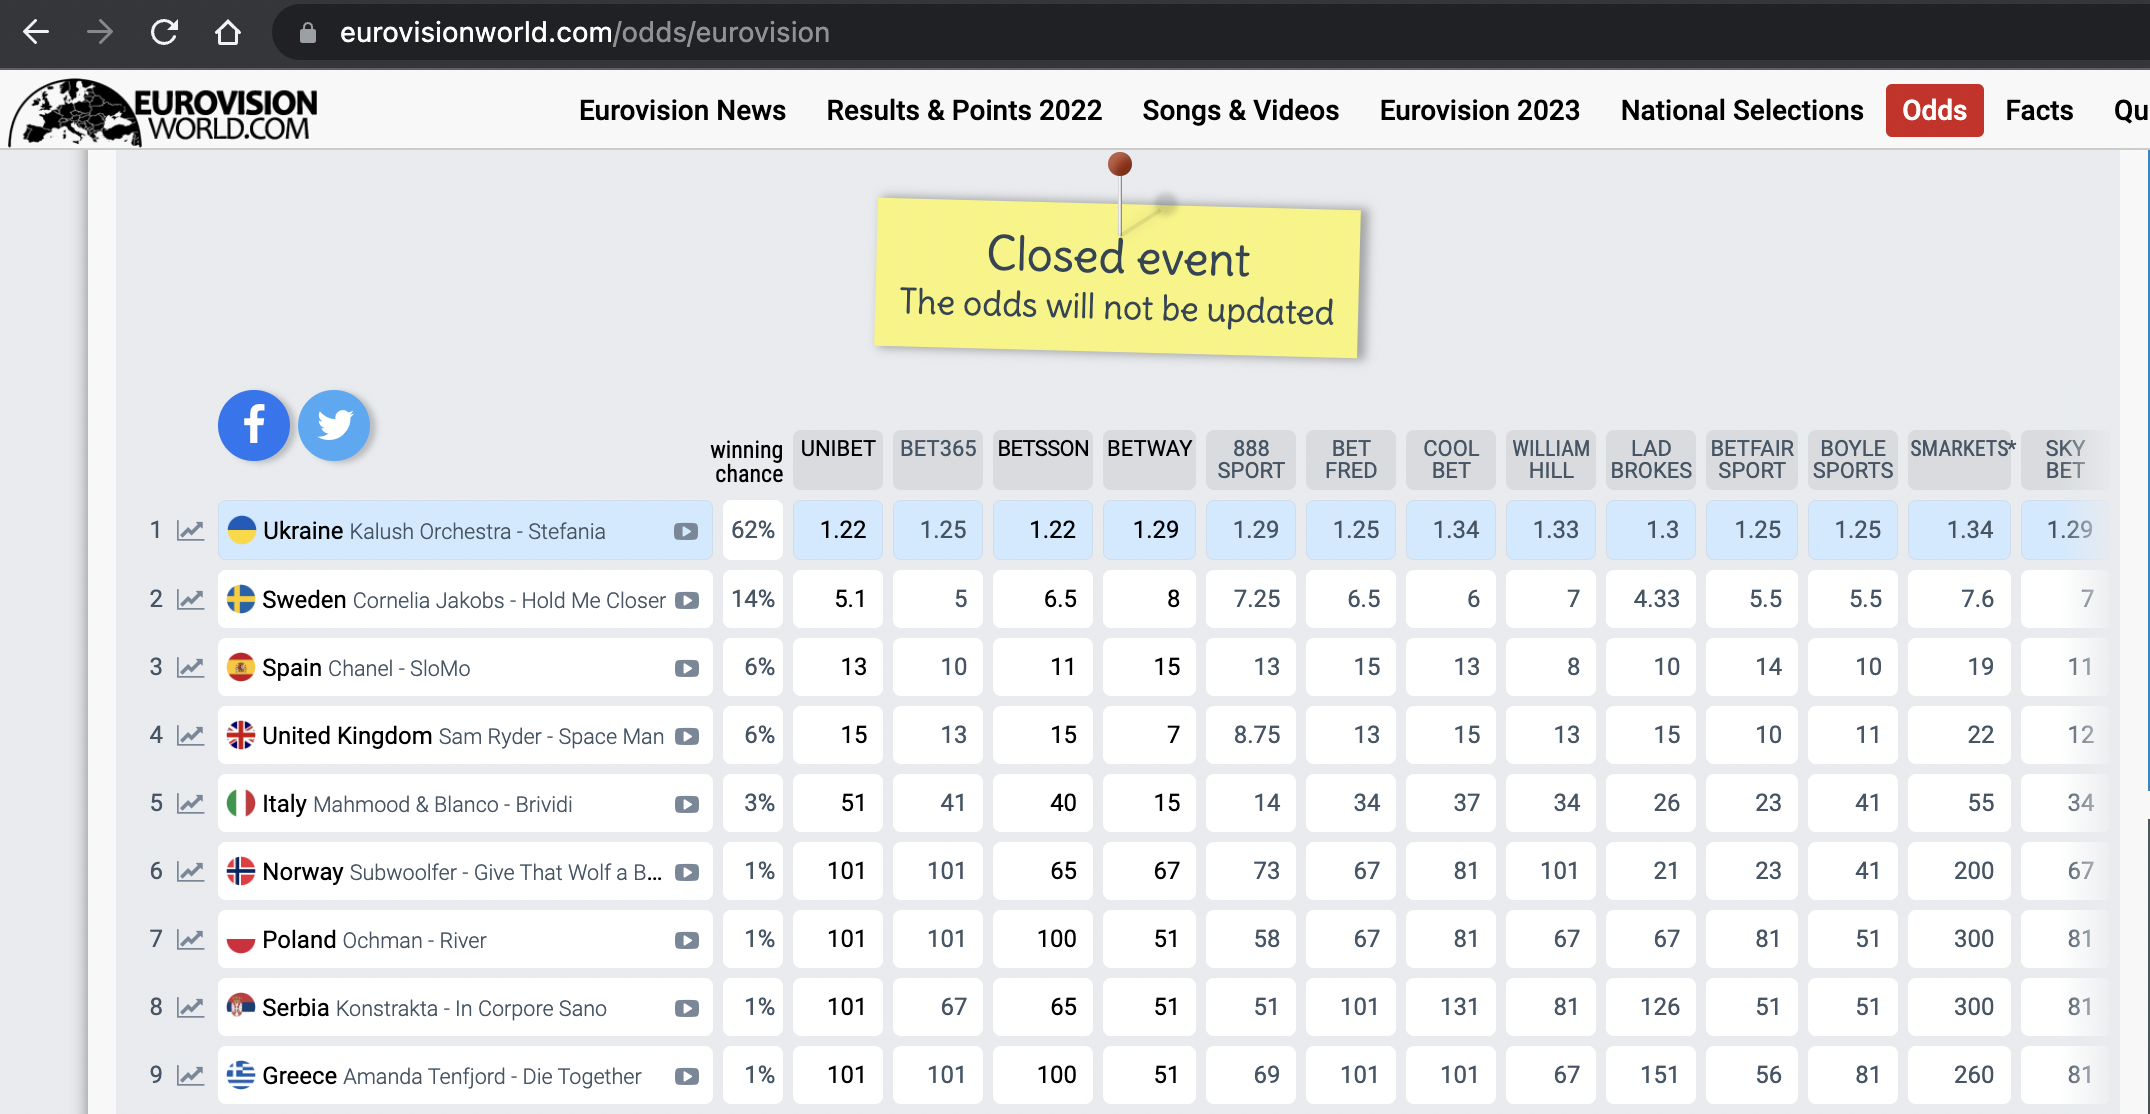

In [20]:
all_urls_parsed[2022]   #change year here to see different years' odds

Rank          Country                                          Song Name  \
0     1          Ukraine                Ukraine Kalush Orchestra - Stefania   
1     2           Sweden            Sweden Cornelia Jakobs - Hold Me Closer   
2     3            Spain                               Spain Chanel - SloMo   
3     4   United Kingdom             UKUnited Kingdom Sam Ryder - Space Man   
4     5            Italy                   Italy Mahmood & Blanco - Brividi   
5     6           Norway        Norway Subwoolfer - Give That Wolf a Banana   
6     7           Poland                              Poland Ochman - River   
7     8           Serbia                Serbia Konstrakta - In Corpore Sano   
8     9           Greece              Greece Amanda Tenfjord - Die Together   
9    10          Moldova   Moldova Zdob şi Zdub & Advahov Brothers - Tre...   
10   11  The Netherlands                        Netherlands S10 - De Diepte   
11   12          Finland                       Finland The Rasmus - Jezebel   
12   13          Estonia                              Estonia Stefan - Hope   
13   14        Australia             Australia Sheldon Riley - Not the Same   
14   15   Czech Republic   Czech Rep.Czech Republic We Are Domi - Lights...   
15   16         Portugal                   Portugal Maro - Saudade, saudade   
16   17          Armenia                           Armenia Rosa Linn - Snap   
17   18          Germany                   Germany Malik Harris - Rockstars   
18   19           France                       France Alvan & Ahez - Fulenn   
19   20       Azerbaijan          Azerbaijan Nadir Rustamli - Fade To Black   
20   21          Iceland                  Iceland Systur - Með hækkandi sól   
21   22          Romania                              Romania WRS - Llámame   
22   23      Switzerland              Switzerland Marius Bear - Boys Do Cry   
23   24          Belgium                 Belgium Jérémie Makiese - Miss You   
24   25        Lithuania                 Lithuania Monika Liu - Sentimentai   

   Winning Chance BET365 UNIBET 888SPORT BETFRED COOLBET WILLIAMHILL  ...  \
0             62%   1.25   1.22     1.29    1.25    1.34        1.33  ...   
1             14%      5    5.1     7.25     6.5       6           7  ...   
2              6%     10     13       13      15      13           8  ...   
3              6%     13     15     8.75      13      15          13  ...   
4              3%     41     51       14      34      37          34  ...   
5              1%    101    101       73      67      81         101  ...   
6              1%    101    101       58      67      81          67  ...   
7              1%     67    101       51     101     131          81  ...   
8              1%    101    101       69     101     101          67  ...   
9              1%    151     81      101      51      81          81  ...   
10             1%    101    101       76     101     131         101  ...   
11            <1%    501    201      251     151     201         126  ...   
12            <1%    251    201      301     101     171         251  ...   
13            <1%    501    226      200     101     151         126  ...   
14            <1%    501    301      301     501     301         201  ...   
15            <1%    501    301      301     501     201         251  ...   
16            <1%    501    301      301     501     301         251  ...   
17            <1%    501    301      201     201     501         301  ...   
18            <1%    751    251      351     501     251         251  ...   
19            <1%    501    351      351     501     301         501  ...   
20            <1%   1001    351      351     501     351         501  ...   
21            <1%   1001    501      601     501     301         301  ...   
22            <1%   1001    351      401     501     301         401  ...   
23            <1%   1001    401      401     501     301         501  ...   
24            <1%   100

## Model 

### Modifying the Odds

The odds needed to be modified in order to be comparable to the average points using the following formula:

$odds = \frac{1}{log(odds)}*a + b$

$a$ and $b$ were chosen experimentally through cross-validation as detailed below.

In [26]:
#function to modify odds

def calc_odds(urls,a,b):
    
    #using only BET365
    odds_dict ={}
    for url_id,url in enumerate(urls):
        final_oddsdata = all_urls_parsed[urls_years[url_id]]
        odds = final_oddsdata[['Country','BET365']]
        odds.columns = ['Country','Odds']

        #converting odds to be comparable w avg points 
        recalc_odds=[]
        for odd in odds.Odds:
            o=float(odd)
            recalc_odds.append((1/np.log(o))*a + b)   
            
        odds.insert(2, "Modified_Odds", recalc_odds)

        odds_dict[urls_years[url_id]] = odds
        
    return odds_dict

### Final Scores Calculation

$Final Scores = Average Points + Modified Odds$

The final scores awarded by each country was then calculated as a simple sum of the historical average score and the modified betting odds. The total scores awarded to each country was then summed up to calculate the ranks for each year. 

### Evaluation Metrics

We are using Mean Squared Error (MSE) per year of the top-5 rankings to evaluate our predictions, as this increased precision of the model as rankings for lower scoring countries are harder to predict. 

For choosing the parameters $a$ and $b$, we will iterate through every value within a range and calcuate the MSE at every step. The values that give us the minimum total MSE will be used for our final predicitons. 

### Cross-Validation
For each year of the contest, the average scores are calculated without including that years' data so that we can evaluate the model's performance on unseen data. 

In [23]:
#function to calculate MSE of 
def MSE_predict(urls_years,odds_dict,cross_validating = True):
    
    predictions = {}
    total_MSE=0
    for year in urls_years:

        #removing current year from data if cross-validating
        if cross_validating:
            esc_scores_temp = esc_scores_final[esc_scores_final['Year']!=year]
        else:
            esc_scores_temp = esc_scores_final[esc_scores_final['Year']<2022]
        #calculate average scores 
        avg_scores_temp = esc_scores_temp.groupby(['From country','To country']).mean().reset_index()
        avg_scores_temp["Final Scores_with Odds"] = ' '


        odds = odds_dict[year]
        #adding avg scores recevied with odds for each country
        for i,p in enumerate(avg_scores_temp['Points']):
            country = avg_scores_temp.loc[i,'To country']
            if country in list(odds.Country):
                odd = odds['Modified_Odds'][odds['Country']==country]
                avg_scores_temp.at[i,"Final Scores_with Odds"] = p + float(odd)
            else:
                avg_scores_temp.at[i,"Final Scores_with Odds"] = 0

        avg_scores_temp = avg_scores_temp.astype({'Final Scores_with Odds': 'float64'})

        #summing all points received for each country
        final_score_prediction = avg_scores_temp.groupby(['To country']).sum()
        final_score_prediction = final_score_prediction.sort_values(by=['Final Scores_with Odds'],ascending=False)
        
        predictions[year] = final_score_prediction.index.tolist()
        y_true = []
        y_pred = []
        for i,t in enumerate(true_rankings[year]):
            if t in final_score_prediction.index.tolist():
                y_true.append(i)
                y_pred.append(final_score_prediction.index.tolist().index(t))
        mse = mean_squared_error(y_true[:5], y_pred[:5])   #mse for top 5 rankings only 
        
        if not cross_validating:
            print("MSE for {} = {}".format(year,mse ))
        total_MSE+=mse
        
    if not cross_validating:  
        print("Total MSE for all years = {}".format(total_MSE))
        print("Average MSE for all years = {}".format(total_MSE/len(urls_years)))
    
    return total_MSE,predictions

In [ ]:
#cross validation to find odds parameters:

all_parameters=[]
for a in range(-10,10):
    for b in np.arange(-3,3,.2):
        odds_dict = calc_odds(urls,a,b)
        total_MSE,p = MSE_predict(urls_years[1:],odds_dict)      

        all_parameters.append([a,b,total_MSE,total_MSE/len(urls_years)])

### Choosing $a$ and $b$ 

We found that $a=8$ and $b=1.8$ gave us the lowest total MSE.

In [24]:
min_MSE = all_parameters[np.argmin(np.array(all_parameters),axis=0)[2]]
print("Parameters with minimum total MSE-")

print("[a, b, Total MSE, Average MSE] = {}".format(min_MSE))

NameError: name 'all_parameters' is not defined

In [27]:
odds_dict = calc_odds(urls,min_MSE[0],min_MSE[1])

### MSE for each year's predictions

The model predicts the rankings for most years with relatively low MSE, except for 2017 and 2018. 

In 2017, it was due to Moldova's unexpected 3rd place ranking, for which the model predicted a rank of 16.
While in 2018, it was due to Austria's 3rd place ranking, for which the model predicted a rank of 19. 

In [28]:
total_MSE,predictions = MSE_predict(urls_years,odds_dict,cross_validating=False)

MSE for 2022 = 14.6
MSE for 2021 = 4.2
MSE for 2019 = 1.2
MSE for 2018 = 51.8
MSE for 2017 = 33.8
MSE for 2016 = 18.0
MSE for 2015 = 0.2
Total MSE for all years = 123.8
Average MSE for all years = 17.685714285714287


In [30]:
#table formatting
def rowStyle(row):
    col2=''
    col3=''
   
    if row['Predicted Top 5'] in true_rankings[year][:5]:
        col2 = 'background-color: #BCF7B3'
    if row['True Top 5'] in predictions[year][:5]:
            col3 = 'background-color: #BCF7B3'
    if row['Predicted Top 5'] == row['True Top 5']:
        col2 = 'background-color: #7FB277'
        col3 = 'background-color: #7FB277'
    return ['',col2,col3]

### 2022 Predictions

The model correctly predicted the winner, Ukraine, which was not surprising since the country had such high probability of winning this year owing to the current war situation there. 

Below, we see the predicted Top 5 rankings for Eurovision 2022. 
Dark green represents correct rank prediciton, while light green represents correct Top-5 prediction. 

In [39]:
year = 2022
pred = pd.DataFrame([range(1,6),predictions[year][:5],true_rankings[year][:5]]).T
pred.columns = ['Rank','Predicted Top 5', 'True Top 5']
pred=pred.style.hide(axis="index")
pred.set_properties(**{'text-align': 'center'})
pred.apply(rowStyle, axis=1)
pred

In [7]:
!pip3 freeze > requirements.txt